# Checking calibrations

Here I am just checking the calibrations measured for all $z-\lambda$ bins.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
%matplotlib inline
plt.rc("errorbar", capsize=3)

In [2]:
sig = 0.4
path = "result_%0.2fsigintr.npy"%sig
data = np.load(path)
print(data.shape)
cs = ['maroon','red','blue','cyan']
zs = [1.0, 0.5, 0.25, 0.]

(6, 16)


In [3]:
def add_points(ax, sigma=None):
    for i in range(4):
        for j in range(4):
            h = i*4+j
            lam = data[3,h]
            c = data[4,h]
            ce = data[5,h]
            if sigma is not None:
                ce = sigma
            if j == 0:
                ax.errorbar(lam, c, ce, color=cs[i], marker='.', label="z=%.2f"%zs[i], ls='')
            else:
                ax.errorbar(lam, c, ce, color=cs[i], marker='.')
    ax.set_ylim(0.9, 1.15)
    ax.legend(loc="upper left")

# Modeling the calibration

In [4]:
def lnlike(params, args, ret_model=False):
    C0, alpha, beta, sigcal = params
    if sigcal < 0: return -1e99
    lams = args['lams']
    zs = args['zs']
    C = args['C']
    Cerr = args['Cerr']
    model = C0*(lams/30.)**alpha * ((1+zs)/1.5)**beta
    if ret_model:
        return model
    X = C - model
    LL = 0
    for i in range(len(X)):
        for j in range(len(X[0])):
            LL += -0.5*np.log(sigcal**2)-0.5*X[i,j]**2/sigcal**2
    return LL

In [5]:
zs = [1.0, 0.5, 0.25, 0.]
zarr = np.zeros((4,4))
lamarr = np.zeros((4,4))
C = np.zeros((4,4))
Ce = np.zeros((4,4))
for i in range(16):
    zarr[i%4, i/4] = zs[i%4]
    lamarr[i%4, i/4] = data[3, i]
    C[i%4, i/4] = data[4,i]
    Ce[i%4, i/4] = data[5,i]
args = {"lams": lamarr, "zs":zarr, "C":C, "Cerr":Ce}

In [6]:
guess = [1.0, 0.02 ,0.02, 1.0]
print(lnlike(guess, args))
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, guess, args=args)
cov = result['hess_inv']
print result

-0.009598898676440438
      fun: -62.9436771585577
 hess_inv: array([[ 4.94273565e-01, -2.04480893e-01,  3.62953381e-02,
        -2.56641469e+01],
       [-2.04480893e-01,  9.19491420e-01,  1.25732829e-02,
        -1.30756130e+01],
       [ 3.62953381e-02,  1.25732829e-02,  9.99431927e-01,
         4.45690901e+00],
       [-2.56641469e+01, -1.30756130e+01,  4.45690901e+00,
         2.05602831e+03]])
      jac: array([699.78307676, 311.46815681, -77.86123323,  26.87309313])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 104
      nit: 1
     njev: 15
   status: 2
  success: False
        x: array([1.03214969, 0.03510477, 0.01565236, 0.01198723])


(0.95, 1.15)

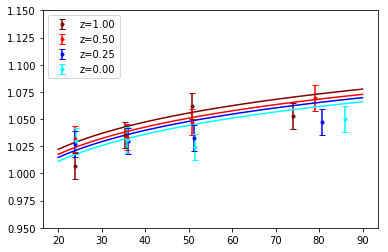

In [7]:
fig, ax = plt.subplots(1,1)
l = np.linspace(20,90)
plot_args = args.copy()
for i,z in enumerate(zs):
    plot_args['lams'] = l
    plot_args['zs'] = z
    model = lnlike(result.x, plot_args, True)
    ax.plot(l, model, c=cs[i])
add_points(ax, result.x[-1])
ax.set_ylim(.95,1.15)